In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "/content/Merged_Disasters(2).csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Perform stratified splitting (70% Train, 15% Validation, 15% Test)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

# Display summary
print("\nData Split Summary:\n", split_summary)
print("\nData split completed and saved as CSV files.")


Data Split Summary:
 Binary_class      Non-Damage  Damage
Train (70%)            10853    1804
Validation (15%)        2326     386
Test (15%)              2326     387
Total                  15505    2577

Data split completed and saved as CSV files.


📊 Class Distribution Before SMOTE:

Train Set:
 Non-Damage    10853
Damage         1804
Name: count, dtype: int64

Validation Set:
 Non-Damage    2326
Damage         386
Name: count, dtype: int64

Test Set:
 Non-Damage    2326
Damage         387
Name: count, dtype: int64

After SMOTE Train Class Distribution:
Damage        10853
Non-Damage    10853
Name: count, dtype: int64

Train Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84     10853
           1       0.89      0.74      0.81     10853

    accuracy                           0.82     21706
   macro avg       0.83      0.82      0.82     21706
weighted avg       0.83      0.82      0.82     21706


Train Accuracy: 0.8228
Train ROC-AUC: 0.9086


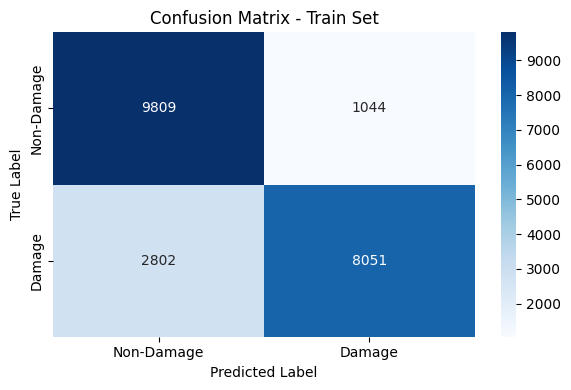

In [ ]:


# Load spaCy and sentence-transformers
import spacy
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load spaCy's English model for morphological features
nlp = spacy.load("en_core_web_sm")

# --- Load Data ---
train_path = "/content/train_data.csv"
val_path = "/content/val_data.csv"
test_path = "/content/test_data.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# --- Preprocess Labels ---
label_map = {'damage': 1, 'non-damage': 0}
for df in [train_df, val_df, test_df]:
    df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
    df['Processed_data'] = df['Processed_data'].fillna("")

# --- Lexical Features: TF-IDF ---
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(train_df['Processed_data'])
X_val_tfidf = vectorizer.transform(val_df['Processed_data'])
X_test_tfidf = vectorizer.transform(test_df['Processed_data'])

# --- Morphological Features: Using spaCy for POS, Lemmatization ---
def extract_morphological_features(texts):
    pos_tags = []
    lemmas = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        pos_tags.append([token.pos_ for token in doc])
        lemmas.append([token.lemma_ for token in doc])
    return pos_tags, lemmas

train_pos_tags, train_lemmas = extract_morphological_features(train_df['Processed_data'])
val_pos_tags, val_lemmas = extract_morphological_features(val_df['Processed_data'])
test_pos_tags, test_lemmas = extract_morphological_features(test_df['Processed_data'])

# --- Combine Lexical (TF-IDF) and Morphological (POS, Lemmas) Features ---
def combine_lexical_morphological(X_tfidf, pos_tags, lemmas):
    # Convert POS tags and Lemmas into feature vectors
    pos_tag_features = np.array([[len(set(tags))] for tags in pos_tags])  # Number of unique POS tags
    lemma_features = np.array([[len(set(lemmas))] for lemmas in lemmas])  # Number of unique Lemmas

    # Concatenate TF-IDF features with POS & Lemma features
    X_combined = np.hstack((X_tfidf.toarray(), pos_tag_features, lemma_features))
    return X_combined

# Apply combination for train, validation, and test
X_train_combined = combine_lexical_morphological(X_train_tfidf, train_pos_tags, train_lemmas)
X_val_combined = combine_lexical_morphological(X_val_tfidf, val_pos_tags, val_lemmas)
X_test_combined = combine_lexical_morphological(X_test_tfidf, test_pos_tags, test_lemmas)

# --- Show Class Distribution Before SMOTE ---
y_train = train_df['Binary_class'].values
y_val = val_df['Binary_class'].values
y_test = test_df['Binary_class'].values

print("📊 Class Distribution Before SMOTE:\n")
print("Train Set:\n", pd.Series(y_train).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))
print("\nValidation Set:\n", pd.Series(y_val).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))
print("\nTest Set:\n", pd.Series(y_test).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))

# --- Apply SMOTE for Balancing Class Distribution ---
smote = SMOTE(sampling_strategy=1, k_neighbors=3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train)

print("\nAfter SMOTE Train Class Distribution:")
print(pd.Series(y_train_smote).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))

# --- Train Random Forest on SMOTE-balanced Data ---
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_smote, y_train_smote)

# --- Evaluate the Model ---
y_train_pred = rf_model.predict(X_train_smote)
y_train_proba = rf_model.predict_proba(X_train_smote)[:, 1]

# Classification Report for Train Set
print("\nTrain Classification Report:")
print(classification_report(y_train_smote, y_train_pred))
# --- Accuracy and ROC-AUC Scores ---
# Calculate Accuracy
accuracy_train = accuracy_score(y_train_smote, y_train_pred)
print(f'\nTrain Accuracy: {accuracy_train:.4f}')

# Calculate ROC-AUC (Area Under the Curve)
roc_auc_train = roc_auc_score(y_train_smote, y_train_proba)
print(f'Train ROC-AUC: {roc_auc_train:.4f}')

# Confusion Matrix for Train Set
cm_train = confusion_matrix(y_train_smote, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Set")
plt.tight_layout()
plt.show()


